## Import the libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import scale # To scale the dataset
from sklearn.svm import SVC # Support vector classifier
from sklearn.metrics import confusion_matrix # To create confusion matrices
from sklearn.metrics import plot_confusion_matrix # To plot
from sklearn.decomposition import PCA

In [3]:
df = pd.read_excel("/content/drive/MyDrive/Datasets for Machine Learning/default of credit card clients.xls",
                   header=1)
df.head() # Taking a sneak peek of the dataset

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


This dataset has 30000 rows and 25 columns


In [6]:
df.rename({"default payment next month":"Default"}, axis='columns', inplace=True)
df.drop(labels = ['ID'], axis= 1, inplace = True)
df.head()
print(f"This dataset has {df.shape[0]} rows and {df.shape[1]} columns")

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Preprocessing the data 

Before we feed the data into a machine learning model, we should see if the values in the dataset are of appropriate types. We should also check for missing values.

If we have missing values:
  1. We can either drop all the rows relevant to that column
  2. We can impute values for the missing valuesprint(f"This 

In [8]:
df.dtypes
# Every column is an integer. No floating points. 

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
Default      int64
dtype: object

In [10]:
round(df.describe(), 2)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default
count,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00
mean,167484.32,1.60,1.85,1.55,35.49,-0.02,-0.13,-0.17,-0.22,-0.27,-0.29,51223.33,49179.08,47013.15,43262.95,40311.40,38871.76,5663.58,5921.16,5225.68,4826.08,4799.39,5215.50,0.22
std,129747.66,0.49,0.79,0.52,9.22,1.12,1.20,1.20,1.17,1.13,1.15,73635.86,71173.77,69349.39,64332.86,60797.16,59554.11,16563.28,23040.87,17606.96,15666.16,15278.31,17777.47,0.42
min,10000.00,1.00,0.00,0.00,21.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-165580.00,-69777.00,-157264.00,-170000.00,-81334.00,-339603.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,50000.00,1.00,1.00,1.00,28.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,3558.75,2984.75,2666.25,2326.75,1763.00,1256.00,1000.00,833.00,390.00,296.00,252.50,117.75,0.00
50%,140000.00,2.00,2.00,2.00,34.00,0.00,0.00,0.00,0.00,0.00,0.00,22381.50,21200.00,20088.50,19052.00,18104.50,17071.00,2100.00,2009.00,1800.00,1500.00,1500.00,1500.00,0.00
75%,240000.00,2.00,2.00,2.00,41.00,0.00,0.00,0.00,0.00,0.00,0.00,67091.00,64006.25,60164.75,54506.00,50190.50,49198.25,5006.00,5000.00,4505.00,4013.25,4031.50,4000.00,0.00
max,1000000.00,2.00,6.00,3.00,79.00,8.00,8.00,8.00,8.00,8.00,8.00,964511.00,983931.00,1664089.00,891586.00,927171.00,961664.00,873552.00,1684259.00,896040.00,621000.00,426529.00,528666.00,1.00


In [11]:
df['SEX'].value_counts()
# 2 is for females and 1 is for males

2    18112
1    11888
Name: SEX, dtype: int64

In [12]:
df['EDUCATION'].value_counts()
# (1 = graduate school; 2 = university; 3 = high school; 4 = others)
# 0, 5 and 6??

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [14]:
df['MARRIAGE'].value_counts()
# (1 = married; 2 = single; 3 = others)
# 0 ??

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [25]:
df.loc[(df['EDUCATION'] == 0) |( df['MARRIAGE'] == 0)].shape[0]
# This is only a small fraction compared to the dataset
# It is safe to remove this

68

In [26]:
df_clean = df.loc[(df['EDUCATION'] != 0) & ( df['MARRIAGE'] != 0)]
df_clean.shape[0]

29932

In [27]:
df_not_default = df_clean[df_clean['Default'] == 0]
df_default = df_clean[df_clean['Default'] == 1]

df_not_default_downsampled = resample(df_not_default, 
                                      replace = False,
                                      n_samples = 1000,
                                      random_state = 42)
len(df_not_default_downsampled)

1000

In [28]:
df_default_downsampled = resample(df_default, 
                                      replace = False,
                                      n_samples = 1000,
                                      random_state = 42)
len(df_default_downsampled)

1000

In [31]:
df_downsampled = pd.concat([df_not_default_downsampled, df_default_downsampled])
len(df_downsampled)

2000

In [39]:
# We should have labels and features seperately
X = df_downsampled.drop(labels=['Default'], axis=1).copy()
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
641,130000,2,3,1,28,0,0,0,0,-2,-2,100143,50456,50000,0,0,0,2500,1000,0,0,0,0
4678,170000,1,3,1,29,0,0,0,0,0,0,165027,168990,172307,35234,32869,33862,7200,7500,1200,1200,1500,1300
16004,180000,2,2,1,29,0,0,0,0,0,0,25781,26000,26310,26662,26166,26176,1800,1800,1500,1056,950,1000
22974,210000,2,2,2,32,-2,-2,-2,-2,-2,-2,355,975,410,0,0,0,979,412,0,0,0,0
17535,190000,2,3,1,45,0,0,0,0,0,0,76433,78472,80548,81778,83082,84811,3300,3331,3359,2663,2751,3000


In [40]:
y = df_downsampled['Default'].copy()
y.head()

641      0
4678     0
16004    0
22974    0
17535    0
Name: Default, dtype: int64

In [43]:
X_encoded = pd.get_dummies(X, columns = ['SEX',
                                         'EDUCATION',
                                         'MARRIAGE',
                                         'PAY_0',
                                         'PAY_2',
                                         'PAY_3',
                                         'PAY_4',
                                         'PAY_5',
                                         'PAY_6'])

X_encoded.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,...,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_7,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7
641,130000,28,100143,50456,50000,0,0,0,2500,1000,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4678,170000,29,165027,168990,172307,35234,32869,33862,7200,7500,1200,1200,1500,1300,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
16004,180000,29,25781,26000,26310,26662,26166,26176,1800,1800,1500,1056,950,1000,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
22974,210000,32,355,975,410,0,0,0,979,412,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
17535,190000,45,76433,78472,80548,81778,83082,84811,3300,3331,3359,2663,2751,3000,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [44]:
X_encoded.shape

(2000, 81)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state = 42)
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

In [46]:
clf_svm = SVC(random_state = 42)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

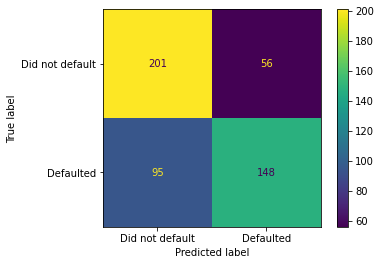

In [47]:
plot_confusion_matrix(clf_svm,
                      X_test_scaled,
                      y_test,
                      values_format = 'd',
                      display_labels = ['Did not default', 'Defaulted'])

In [50]:
# let's a cross validation
param_grid = [
              {
                  "C":[0.5, 1, 10, 100],
               'gamma':['scale', 1, 0.1, 0.01, 0.001, 0.0001],
               'kernel':['rbf']
              }
]

optimal_params = GridSearchCV(
    SVC(), 
    param_grid,
    cv=5,
    scoring = 'accuracy',
    verbose = 0
)

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [51]:
clf_svm = SVC(random_state=42, C=100, gamma = 0.001)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

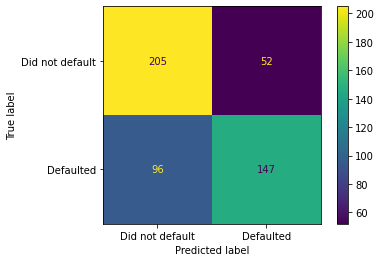

In [52]:
plot_confusion_matrix(clf_svm,
                      X_test_scaled,
                      y_test,
                      values_format = 'd',
                      display_labels = ['Did not default', 'Defaulted'])